In [1]:
import glob
import py3Dmol
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.PDB import PDBIO, PDBParser
from metfish.utils import get_rmsd, align_structures

/tmp/ipykernel_1009695/2267753333.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# define data collating function
def create_af_process_df(conformers, experimental_dir, af_output_dir, manipulation='none'):
    conf_data = []
    for conf in conformers:
        pair_id = [ind for ind, p in enumerate(pairs) if conf in p][0]                 # add 'pair_id' value to all conformer pairs
        alt_conf = [(set(p) - {conf}).pop() for p in pairs if conf in p][0]            # get opposite conformer (set difference)
        exp_fname = f'{experimental_dir}//{conf}_atom_only.pdb'                        # get the pdb/experimental data structure filename  
        if any(glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')):            # find filenames of the first model over all recycling iterations
            af_fnames = glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')
        else:
            af_fnames = glob.glob(f'{af_output_dir}//{alt_conf}*rank_001*.r[0-9].pdb')        
        recycling_iter = [int(f.split('.pdb')[0][-1]) for f in af_fnames]              # get recycling iteration values
        rmsd = [get_rmsd(exp_fname, af) for af in af_fnames]                           # calculate rmsd between recycling iteration and experimental data

        conf_data.append(pd.DataFrame(dict(name=conf, 
                                           af_fname=af_fnames, 
                                           exp_fname=exp_fname, 
                                           recycling_iteration=recycling_iter, 
                                           rmsd=rmsd,
                                           alt_conf=alt_conf,
                                           pair_id=pair_id,
                                           manipulation=manipulation)))
    return conf_data

In [3]:
# set paths for different experimental and alphafold output files
working_dir = '//pscratch//sd//s//smprince//projects//metfish//data'
output_dir_no_manipulation = f'{working_dir}//output//no_manipulation//240213'
output_dir_with_manipulation = f'{working_dir}//output//replace_conformer//240213'
experimental_dir = f'{working_dir}//pdbs'

# load pair dataframe
pair_df = pd.read_csv(f'{working_dir}//apo_holo_pairs.csv')
pairs = list(zip(pair_df['apo_id'], pair_df['holo_id']))
conformers = [conf for p in pairs for conf in p]

# create conformer dataframes
df_no_maniplation = create_af_process_df(conformers, experimental_dir, output_dir_no_manipulation, manipulation='none')
df_with_manipulation = create_af_process_df(conformers, experimental_dir, output_dir_with_manipulation, manipulation='template')

conf_df = pd.concat([*df_no_maniplation, *df_with_manipulation])
conf_df = conf_df.sort_values(['pair_id', 'name','manipulation', 'recycling_iteration'])
conf_df.head()

name                                           af_fname  \
0  2BEM_A  //pscratch//sd//s//smprince//projects//metfish...   
4  2BEM_A  //pscratch//sd//s//smprince//projects//metfish...   
1  2BEM_A  //pscratch//sd//s//smprince//projects//metfish...   
2  2BEM_A  //pscratch//sd//s//smprince//projects//metfish...   
3  2BEM_A  //pscratch//sd//s//smprince//projects//metfish...   

                                           exp_fname  recycling_iteration  \
0  //pscratch//sd//s//smprince//projects//metfish...                  0.0   
4  //pscratch//sd//s//smprince//projects//metfish...                  1.0   
1  //pscratch//sd//s//smprince//projects//metfish...                  2.0   
2  //pscratch//sd//s//smprince//projects//metfish...                  3.0   
3  //pscratch//sd//s//smprince//projects//metfish...                  4.0   

       rmsd  alt_conf  pair_id manipulation  
0  0.483489  2LHS-6_A       35         none  
4  0.448522  2LHS-6_A       35         none  
1  0.445539  2LHS-6_A       35         none  
2  0.442415  2LHS-6_A       35         none  
3  0.443920  2LHS-6_A       35         none

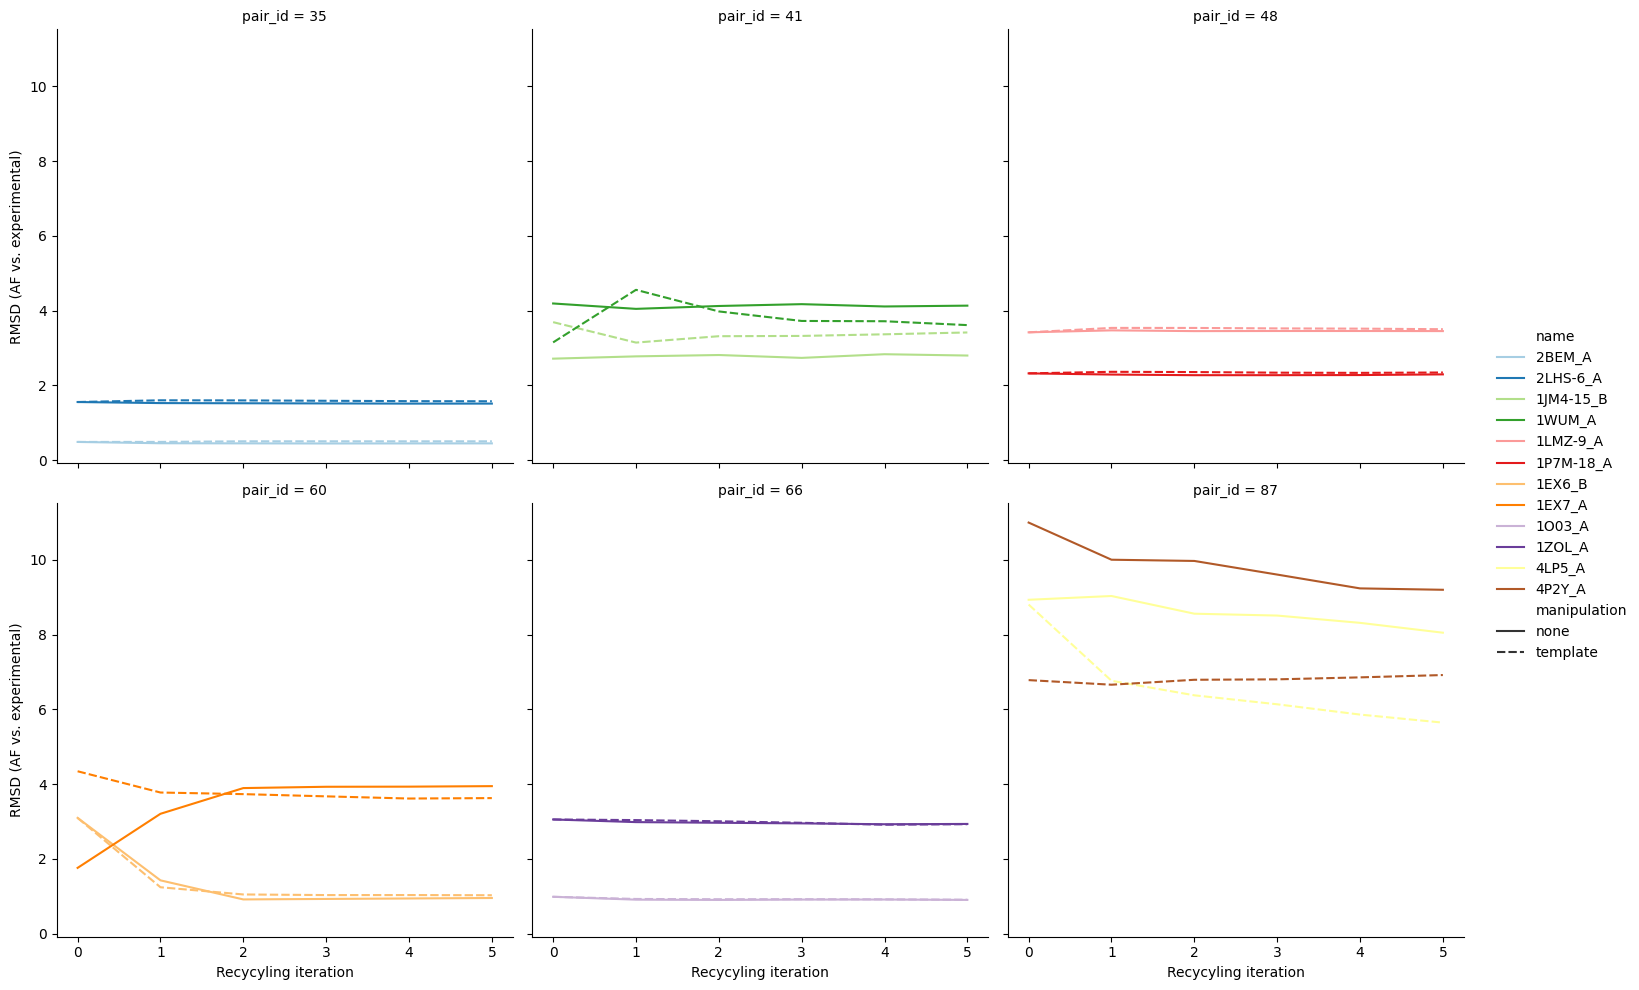

In [4]:
# plot structure similarity across recycling iterations
# each subplot is a pair of apo/holo conformers (same sequence, different conformations)
# y-axis indicates RMSD between the AF output vs. experimental structure (lower values = more similar)
# x-axis indicates recycling iterations (0 is after one pass through AF network, 5 is end)
# solid lines indicate the AF prediction without any manipulation 
# (i.e. same sequence/output for each conformer pair, just two different similarity scores over time)
# dashed lines indicate the AF prediction when the experimental structure for that conformer was injected at each recycling iteration
# (i.e. trying to drive alphafold prediction to be more similar to that conformer)
g = sns.relplot(data=conf_df, 
                x='recycling_iteration',
                y='rmsd', 
                col='pair_id', 
                hue='name', 
                style='manipulation', 
                col_wrap=3, 
                kind='line', 
                palette=sns.color_palette("Paired"))

(g.set_axis_labels("Recycyling iteration", "RMSD (AF vs. experimental)")
  .tight_layout())

In [5]:
# make structure visualization function
def plot_recycling_iteration(df_row, colnames):
    view.addModel(open(df_row['exp_fname'], "r").read(), "pdb", viewer=(0, df_row['recycling_iteration']))
    view.addModel(open(df_row[colnames[0]], "r").read(), "pdb", viewer=(0, df_row['recycling_iteration']))
    
    view.addModel(open(df_row['exp_fname'], "r").read(), "pdb", viewer=(1, df_row['recycling_iteration']))
    view.addModel(open(df_row[colnames[1]], "r").read(), "pdb", viewer=(1, df_row['recycling_iteration']))

    view.setStyle({'model':0}, {'cartoon':{'color':'white'}}, viewer=(0, df_row['recycling_iteration']))
    view.setStyle({'model':1}, {'cartoon':{'color':'blue'}}, viewer=(0, df_row['recycling_iteration']))

    view.setStyle({'model':0}, {'cartoon':{'color':'white'}}, viewer=(1, df_row['recycling_iteration']))
    view.setStyle({'model':1}, {'cartoon':{'color':'purple'}}, viewer=(1, df_row['recycling_iteration']))

In [6]:
# visualize structural representations across recycling iterations 
# each column indicates a recycling iteration (left = start of AF run, right = end)
# top row is the AF structural output without any manipulations (blue = AF prediction, white = experimental structure)
# bottom row is the AF structural output with manipulations (purple = AF prediction, white = experimental structure)
pdb_name = "1EX7_A"
manipulations = ('none', 'template')

example_df = (conf_df
              .query(f"name == '{pdb_name}'")
              .pivot(columns='manipulation', values='af_fname', index=['name', 'exp_fname', 'recycling_iteration'])
              .reset_index()
              .sort_values('recycling_iteration'))

aligned_colnames = [f'{m}_aligned' for m in manipulations]
for m in manipulations:
    example_df[f'{m}_aligned'] = example_df.apply(lambda x: align_structures(x['exp_fname'], x[m]), axis=1)
    
view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js", viewergrid=(2, 6))
example_df.apply(lambda x: plot_recycling_iteration(x, aligned_colnames), axis=1)
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol